This notebook shows how multiple transformation steps can be autmated with <strong>skLearn Pipelines</strong><br>
Also we'll use <strong>StratifiedShuffleSplit</strong> To keep the target variable proportion same in Testing and Training data

In [1]:
import pandas as pd
import numpy as np

housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


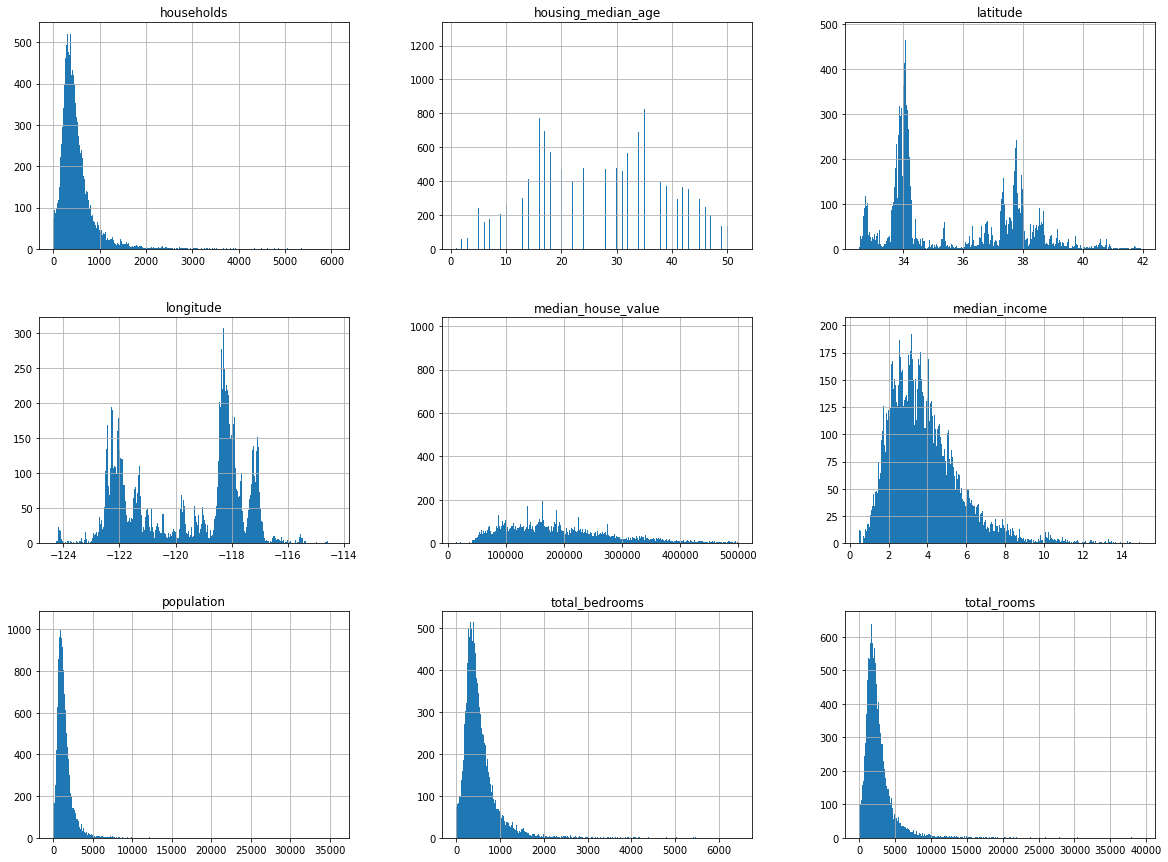

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=500,figsize=(20,15))
plt.show()

In [3]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<strong>Generate a test set using StratifiedShuffleSplit</strong>

In [4]:
housing['income_cut'] = pd.cut(housing['median_income'], bins=[0.,1.5,3.,4.5,6.,np.inf], labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit as SSS

sp = SSS(n_splits=1, test_size=0.2, random_state=42)

for train_i, test_i in sp.split(housing,housing['income_cut']):##Will run n_splits times
    print(len(train_i),len(test_i))##train_i => train_index contains all the indexes for training
    strat_train_set = housing.loc[train_i]
    strat_test_set = housing.loc[test_i]

16512 4128


In [5]:
strat_test_set['income_cut'].value_counts() / len(strat_test_set)
##See both training and test sets have same proportion of our target variable

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cut, dtype: float64

In [6]:
strat_train_set['income_cut'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cut, dtype: float64

In [7]:
for s in (strat_train_set, strat_test_set):
    s.drop('income_cut', axis=1, inplace=True)

<strong>EDA</strong>

In [8]:
housing = strat_train_set.copy()

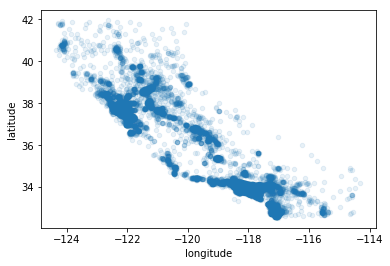

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [11]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000178BB356C88>,
      dtype=object)

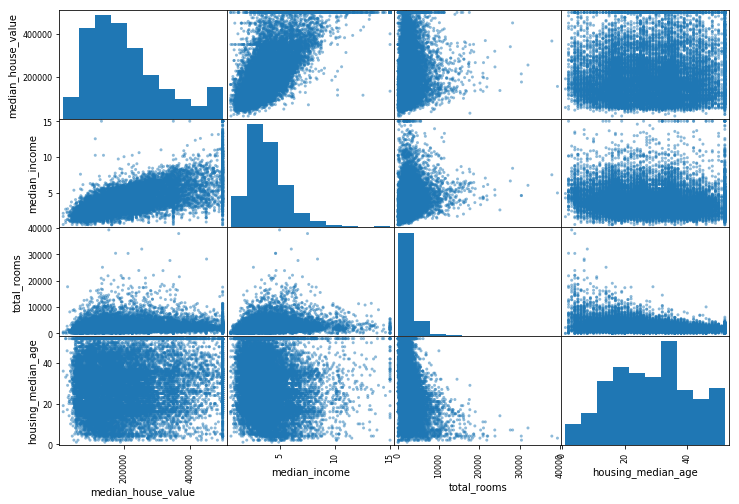

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

[0, 16, 0, 550000]

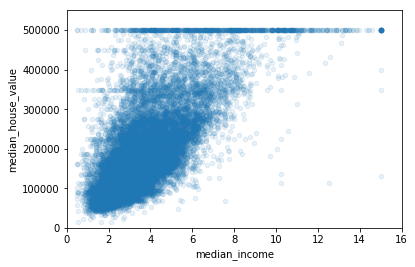

In [15]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Altering DataFrame using pipelines

In [16]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [23]:
from sklearn.impute import SimpleImputer

##As we need to do a plenty of transformation, It will be good to create a pipeline itself

from sklearn.base import BaseEstimator,TransformerMixin

##Create a class with fit and transform methods for developing and adding new attributes
class deriveNewAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.room_ColIndex = 3
        self.household_ColIndex = 6
        self.population_ColIndex = 5
        
    def fit(self, X,y=None):
        return self
    def transform(self, X):
        ## Transform this X to add new derived columns
        
        ##basically select room column/ household column
        rooms_per_household = X[:,self.room_ColIndex] / X[:, self.household_ColIndex]
        population_per_household = X[:, self.population_ColIndex] / X[:, self.household_ColIndex]
        
        ##Just joins everything toger column wise.
        return np.c_[X, rooms_per_household, population_per_household]

    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', deriveNewAttributes()),
        ('std_scaler', StandardScaler()),
    ])

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing.columns)
num_attribs.remove('ocean_proximity')

cat_attribs = ["ocean_proximity"]

##Does operation Column wise
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [32]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [33]:
housing_prepared.shape

(16512, 15)

<strong> Model Building </strong>

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
##testing for few data
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [211888.26540421 321274.25149998 210853.46010112  62261.10820843
 194921.76527689]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [37]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.76054233838

In [47]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
## as other metrics (like f1-score) are higher the better, That's not the case with regression scores (rmse)
##Thus we take a negative of this score to have same functionality, i'e higher the score, the better

lin_rmse_scores = np.sqrt(-score) ##Square root of the scores
print("Mean:"+str(lin_rmse_scores.mean()))
print("Std Deviation:"+str(lin_rmse_scores.std()))

##Use of cross validation can be seen with std. We know how much deviation the score can show

Mean:69192.94964203317
Std Deviation:2674.1447265970173


We got a RMSE of <strong>69192.9</strong> using simple Lnr. Regression Model (Training Set)

<strong> RandomForests </strong> -- With GridSerch to optimize its hyperparams, along with cross validation

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [10, 30, 35 , 45 ,50], 'max_features': [2, 4, 6, 8]}
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [61]:
cvres = grid_search.cv_results_

print(grid_search.best_params_)

grid_search_RandomFrst_scores = cvres["mean_test_score"]
min(np.sqrt(-grid_search_RandomFrst_scores))

{'max_features': 6, 'n_estimators': 50}


49273.25507972137

We got a RMSE of <strong>49273.25</strong>. We successfully fine tuned the Model.(Training Set)<br> 
(As compared to simple Lnr. Regression Model)

We are doing grid serach on limited search space, We will use <strong>RandomizedSearchCV</strong> 

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)## Same random seed to compare with previousmodel

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [65]:
cvres = rnd_search.cv_results_

print(rnd_search.best_params_)

rnd_search_RandomFrst_scores = cvres["mean_test_score"]
min(np.sqrt(-rnd_search_RandomFrst_scores))

{'max_features': 7, 'n_estimators': 180}


48674.433416827786

We got a RMSE of <strong>48674.4</strong>. We successfully fine tuned the Model Again.(Training Set)<br> 
(As compared to Grid search Tuning)

In [67]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

<strong>Error on Testing Data</strong>

In [71]:
BEST_MODEL= grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) ## Just transformming -- We have already Fit it on training set
final_predictions = BEST_MODEL.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)


final_rmse= np.sqrt(final_mse)

final_rmse

46732.07217741

We got a RMSE of <strong>46732.07</strong> on Test set. This is not bad

<strong>Confidence Interval</strong>

In [77]:
## Get a range for 95% confidence using zscore

from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
m = len(squared_errors)
mean = squared_errors.mean()

zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(44734.96150510355, 48647.264662324225)

In [78]:
##import joblib
##joblib.dump(BEST_MODEL, "cali_housing_regression.pkl")


['my_model.pkl']